# LSTM for time series prediction (Modified)

The idea of using a Neural Network (NN) to predict the stock price movement on the market is as old as NNs.
Intuitively, it seems difficult to predict the future price movement looking only at its past. 
There are many tutorials on how to predict the price trend or its power, which simplifies the problem.
I've decided to try to predict Volume Weighted Average Price with LSTM because it seems challenging and fun.

In this blog post, I am going to train a Long Short Term Memory Neural Network (LSTM) with PyTorch on Bitcoin trading data and use the it to predict the price of unseen trading data. 
I had quite some difficulties with finding intermediate tutorials with a repeatable example of training an LSTM for time series prediction, 
so I've put together this [Jupyter notebook]({{site.url}}/assets/notebooks/2019-09-27-time-series-prediction-with-lstm.ipynb) to help you to get started.

## Loading Necessary Dependencies

Let's import the libraries that we are going to use for data manipulation, visualization, training the model, etc.
We are going to train the LSTM using PyTorch library.

In [1]:
%matplotlib inline

import glob
from platform import python_version

import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch

In [2]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.0
pandas==0.23.4
numpy==1.17.0
sklearn==0.21.3
torch==1.3.0.post2
matplotlib==3.0.3


In [3]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
# plt.rcParams[
#     "figure.facecolor"
# ] = "w"  # force white background on plots when using dark mode in JupyterLab

## Trading Data

We are going to analyze XBTUSD trading data from BitMex. 
The daily files are publicly available to [download](https://public.bitmex.com/?prefix=data/trade/).
I didn't bother to write the code to download the data automatically,
I've simply clicked a couple of times to download the files.

Let's lists all the files, read them to a pandas DataFrame and filter the trading data by XBTUSD symbol.
It is important to sort the DataFrame by timestamp as there are multiple daily files so that they don't get mixed up.

In [7]:
# DATA_DIR = "/Volumes/WD ExFAT/btc_small"
DATA_DIR = "./replications"
files = sorted(glob.glob("{}/*.csv.gz".format(DATA_DI)))
files

['./replications/20170112.csv.gz']

In [8]:
df = pd.concat(map(pd.read_csv, files))
df.shape

(14217, 10)

In [9]:
df = df[df.symbol == 'XBTUSD']
df.shape

(9978, 10)

In [10]:
df.timestamp = pd.to_datetime(df.timestamp.str.replace('D', 'T'))
df = df.sort_values('timestamp')

In [11]:
df.set_index('timestamp', inplace=True)

In [12]:
df.head()

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,
2017-01-12 00:00:05.075487,XBTUSD,Buy,12,764.24,PlusTick,adfaccfa-24e6-1ada-1908-23a2069d63ab,1570188,0.015702,12.0
2017-01-12 00:00:05.075487,XBTUSD,Buy,188,764.37,PlusTick,2630207e-2171-1eea-896d-732de2cf3cd8,24595476,0.245955,188.0
2017-01-12 00:00:48.228429,XBTUSD,Sell,2000,762.02,MinusTick,0380b8ce-5ada-c675-48fb-d222787292aa,262460000,2.624600,2000.0
2017-01-12 00:01:07.575589,XBTUSD,Sell,2000,761.98,MinusTick,857c2c1d-407f-c43f-3366-d977e304f95b,262474000,2.624740,2000.0
2017-01-12 00:01:19.605630,XBTUSD,Sell,36,760.92,MinusTick,64a7230a-1cc0-76f6-b9de-1d7c9364ecc2,4731120,0.047311,36.0


Each row represents a trade:
- timestamp in microsecond accuracy,
- symbol of the contract traded,
- side of the trade, buy or sell,
- size represents the number of contracts (the number of USD traded),
- price of the contract,
- tickDirection describes an increase/decrease in the price since the previous transaction,
- trdMatchID is the unique trade ID,
- grossValue is the number of satoshis exchanged,
- homeNotional is the amount of XBT in the trade,
- foreignNotional is the amount of USD in the trade.

We are going to use 3 columns: timestamp, price and foreignNotional. 

## Data Preprocessing

Let's calculate [Volume Weighted Average Price (VWAP)](https://www.investopedia.com/terms/v/vwap.asp) in 1 minute time intervals. 
The data representation where we group trades by the predefined time interval is called time bars. 
Is this the best way to represent the trade data for modeling? 
According to Lopez de Prado, trades on the market are not uniformly distributed over time. 
There are periods with high activity, eg. right before future contracts expire, and grouping of data in predefined time intervals would oversample the data in some time bars and undersample it at others. 
[Financial Machine Learning Part 0: Bars](https://towardsdatascience.com/financial-machine-learning-part-0-bars-745897d4e4ba) is a nice summary of the 2nd Chapter of Lopez de Prado's book [Advances in Financial Machine Learning Book](https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089).
Time bars may not be the best data representation, but we are going to use them regardless.

In [13]:
df_vwap = df.groupby(pd.Grouper(freq="1Min")).apply(
    lambda row: pd.np.sum(row.price * row.foreignNotional) / pd.np.sum(row.foreignNotional)
)
df_vwap.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


(1440,)

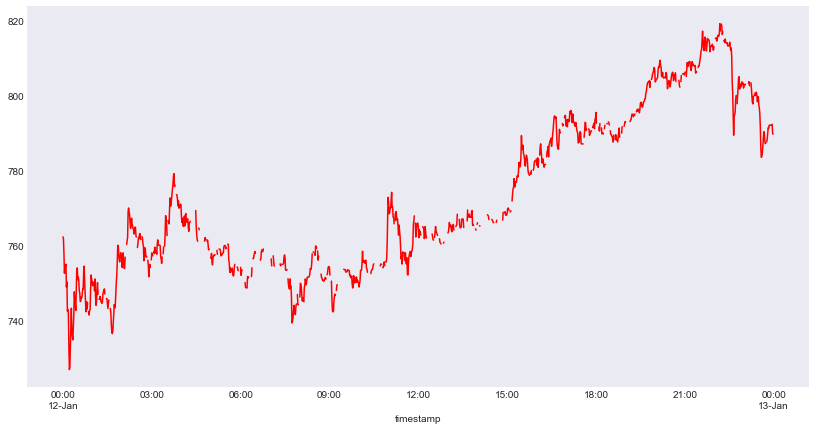

In [14]:
ax = df_vwap.plot(figsize=(14, 7), color="red")

The plot shows time bars with VWAP from 1st of August till the 17th of September 2019.
We are going to use the first part of the data for the training set, part in-between for validation set and the last part of the data for the test set (vertical lines are delimiters).
We can observe volatility in the VWAP, where the price reaches its highs in the first part of August and lows at the end of August. 
The high and low are captured in the training set, which is important, as the model most probably wouldn't work well on unseen VWAP intervals.

In [15]:
df_train = df_vwap[df_vwap.index < "2019-10-25"].to_frame(name="vwap")
df_train.shape

(1440, 1)

In [17]:
df_val = df_vwap[(df_vwap.index >= "2019-10-25") & (df_vwap.index < "2019-10-26")].to_frame(name="vwap")
df_val.shape

(0, 1)

In [18]:
df_test = df_vwap[df_vwap.index >= "2019-10-26"].to_frame(name='vwap')
df_test.shape

(0, 1)

### Data Scaling 

To help the LSTM model to converge faster it is important to scale the data.
It is possible that large values in the inputs slows down the learning. 
We are going to use StandardScaler from sklearn library to scale the data. 
The scaler is fit on the training set and it is used to transform the unseen trade data on validation and test set. 
If we would fit the scalar on all data, the model would overfit and it would achieve good results on this data, but performance would suffer on the real world data.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(df_train)
val_arr = scaler.transform(df_val)
test_arr = scaler.transform(df_test)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

### Data Transformation

After scaling we need to transform the data into a format that is appropriate for modeling with LSTM. 
We transform the long sequence of data into many shorter sequences (100 time bars per sequence) that are shifted by a single time bar.

The plot below shows the first and the second sequence in the training set. 
The length of both sequences is 100 time bars.
We can observe that the target of both sequences is almost the same as the feature, 
the differences are in the first and in the last time bar.

How does the LSTM use the sequence in the training phase?
Let's focus on the 1st sequence.
The model takes the feature of the time bar at index 0 and it tries to predict the target of the time bar at index 1.
Then it takes the feature of the time bar at index 1 and it tries to predict the target of the time bar at index 2, etc.
The feature of 2nd sequence is shifted by 1 time bar from the feature of 1st sequence, the feature of 3rd sequence is shifted by 1 time bar from 2nd sequence, etc.
With this procedure, we get many shorter sequences that are shifted by a single time bar.

Note that in classification or regression tasks, we usually have a set of features and a target that we are trying to predict.
In this example with RNN, the feature and the target are from the same sequence, the only difference is that the target is shifted by 1 time bar. 

In [20]:
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var

In [21]:
from torch.autograd import Variable

seq_len = 100

x_train, y_train = transform_data(train_arr, seq_len)
x_val, y_val = transform_data(val_arr, seq_len)
x_test, y_test = transform_data(test_arr, seq_len)

NameError: name 'val_arr' is not defined

In [22]:
x_train;

In [37]:
def plot_sequence(axes, i, x_train, y_train):
    axes[i].set_title("%d. Sequence" % (i + 1))
    axes[i].set_xlabel("Time bars")
    axes[i].set_ylabel("Scaled VWAP")
    axes[i].plot(range(seq_len), x_train[i].cpu().numpy(), color="r", label="Feature")
    axes[i].plot(range(1, seq_len + 1), y_train[i].cpu().numpy(), color="b", label="Target")
    axes[i].legend()

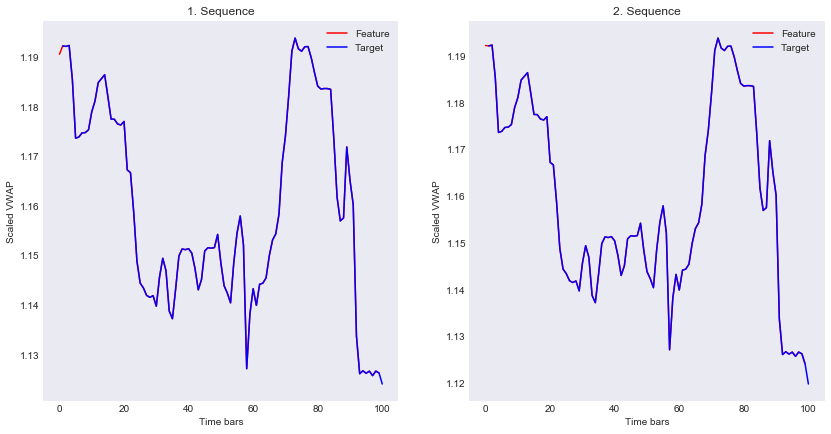

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train)
plot_sequence(axes, 1, x_train, y_train)

## Long Short Term Memory Neural Network

The Long Short Term Memory neural network is a type of a Recurrent Neural Network (RNN). 
RNNs use previous time events to inform the later ones.
For example, to classify what kind of event is happening in a movie, the model needs to use information about previous events.
RNNs work well if the problem requires only recent information to perform the present task. 
If the problem requires long term dependencies, RNN would struggle to model it.
The LSTM was designed to learn long term dependencies. 
It remembers the information for long periods.
LSTM was introduced by [S Hochreiter, J Schmidhuber](https://www.mitpressjournals.org/doi/abs/10.1162/neco.1997.9.8.1735) in 1997.
To learn more about LSTMs read a great [colah blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) which offers a good explanation. 

The code below is an implementation of a stateful LSTM for time series prediction. 
It has an LSTMCell unit and a linear layer to model a sequence of a time series. 
The model can generate the future values of a time series and 
it can be trained using teacher forcing (a concept that I am going to describe later).

In [39]:
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [40]:
import time
import random


class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [41]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [42]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

## Training the LSTM

We train LSTM with 21 hidden units. 
A lower number of units is used so that it is less likely that LSTM would perfectly memorize the sequence.
We use Mean Square Error loss function and Adam optimizer. 
Learning rate is set to 0.001 and it decays every 5 epochs. 
We train the model with 100 sequences per batch for 15 epochs.
From the plot below, we can observe that training and validation loss converge after sixth epoch.

In [43]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [44]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

Epoch 1 Train loss: 0.94. Validation loss: 1.49. Avg future: 0.00. Elapsed time: 6.70s.
Epoch 2 Train loss: 0.50. Validation loss: 0.58. Avg future: 0.00. Elapsed time: 6.57s.
Epoch 3 Train loss: 0.10. Validation loss: 0.63. Avg future: 0.00. Elapsed time: 6.64s.
Epoch 4 Train loss: 0.09. Validation loss: 0.40. Avg future: 0.00. Elapsed time: 6.78s.
Epoch 5 Train loss: 0.04. Validation loss: 0.35. Avg future: 0.00. Elapsed time: 7.01s.
Epoch 6 Train loss: 0.03. Validation loss: 0.33. Avg future: 0.00. Elapsed time: 6.89s.
Epoch 7 Train loss: 0.03. Validation loss: 0.31. Avg future: 0.00. Elapsed time: 6.78s.
Epoch 8 Train loss: 0.03. Validation loss: 0.30. Avg future: 0.00. Elapsed time: 6.71s.
Epoch 9 Train loss: 0.03. Validation loss: 0.30. Avg future: 0.00. Elapsed time: 6.94s.
Epoch 10 Train loss: 0.03. Validation loss: 0.30. Avg future: 0.00. Elapsed time: 6.85s.
Epoch 11 Train loss: 0.03. Validation loss: 0.30. Avg future: 0.00. Elapsed time: 6.63s.
Epoch 12 Train loss: 0.03. Val

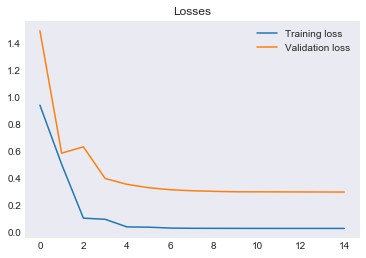

In [45]:
optimization_1.plot_losses()

Let's evaluate the model on the test set.
The future parameter is set to 5, which means that the model outputs the VWAP where it believes it will be in the next 5 time bars (5 minutes in our example).
This should make the price change visible few time bars before it occurs.

On the plot below, we can observe that predicted values closely match actual values of VWAP, which seems great on the first sight.
But the future parameter was set to 5, which means that the orange line should react before a spike occurs instead of covering it.

Test loss 9.6368


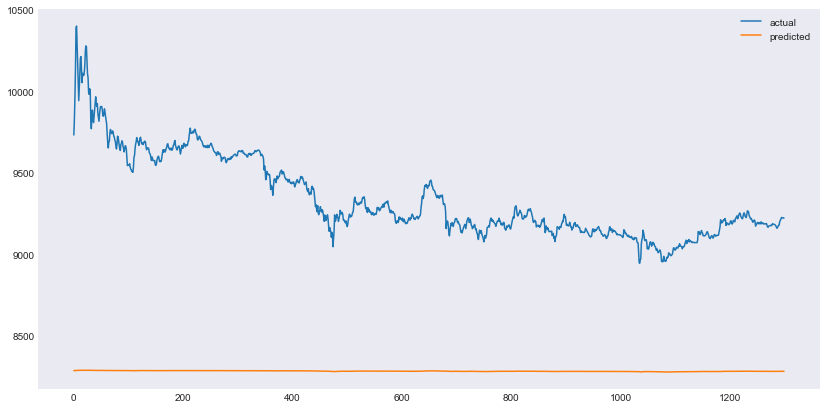

In [49]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

When we zoom into the spikes (one on the start and the other on the end of the time series).
We can observe that predicted values mimic the actual values.
When the actual value changes direction, predicted value follows, which doesn't help us much.
The same happens when we increase the future parameter (like it doesn't affect the predicted line).

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[2350:2450].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[16000:17500].plot(ax=axes[1], figsize=(14, 7))

TypeError: Empty 'DataFrame': no numeric data to plot

Let's generate 1000 time bars for the first test sequence with the model and compare predicted, generated and actual VWAP.
We can observe that while the model outputs predicted values, they are close to actual values.
But when it starts to generate values, the output almost resembles the sine wave. 
After certain period values converge to 9600.

In [51]:
x_sample = x_test[0].reshape(1, -1)
y_sample = df_test.vwap[:1100]
 
y_pred1 = generate_sequence(scaler, optimization_1.model, x_sample)

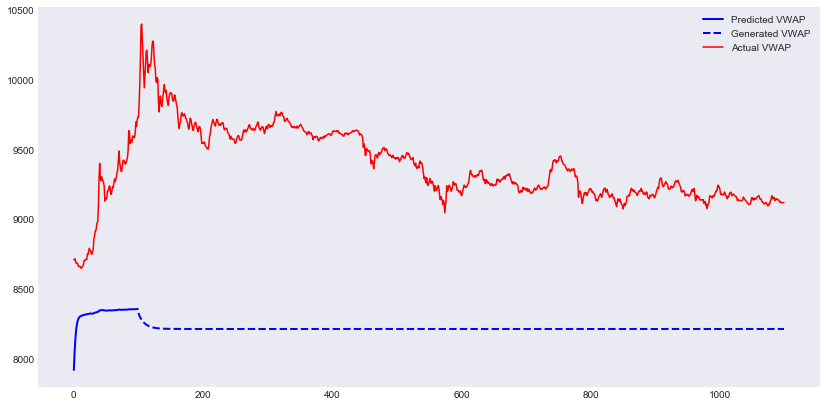

In [52]:
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred1[0][:100], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(100, 1100), y_pred1[0][100:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual VWAP")
plt.legend()

This behavior could occur because the model was trained only with true inputs and never with generated inputs.
When the model gets fed the generated output on the input, it does a poor job of generating the next values.
Teacher forcing is a concept that deals with this issue.

## Teacher Forcing

The [Teacher forcing](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/) is a method for training Recurrent Neural Networks that use the output from a previous time step as an input.
When the RNN is trained, it can generate a sequence by using the previous output as current input.
The same process can be used during training, but the model can become unstable or it does not converge.
Teacher forcing is an approach to address those issues during training. 
It is commonly used in language models. 

We are going to use an extension of Teacher forcing, called [Scheduled sampling](https://arxiv.org/abs/1506.03099).
The model will use its generated output as an input with a certain probability during training.
At first, the probability of a model seeing its generated output is small and then it gradually increases during training.
Note that in this example, we use a random probability, which doesn't increase during the training process.

Let's train a model with the same parameters as before but with the teacher forcing enabled.
After 7 epochs, the training and validation loss converge.

In [53]:
model_2 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = optim.lr_scheduler.StepLR(optimizer_2, step_size=5, gamma=0.1)
optimization_2 = Optimization(model_2, loss_fn_2,  optimizer_2, scheduler_2)

In [54]:
optimization_2.train(x_train, y_train, x_val, y_val, do_teacher_forcing=True)

Epoch 1 Train loss: 0.95. Validation loss: 1.44. Avg future: 26.90. Elapsed time: 6.02s.
Epoch 2 Train loss: 0.50. Validation loss: 0.36. Avg future: 22.33. Elapsed time: 6.05s.
Epoch 3 Train loss: 0.05. Validation loss: 0.45. Avg future: 26.95. Elapsed time: 6.46s.
Epoch 4 Train loss: 0.06. Validation loss: 0.32. Avg future: 27.90. Elapsed time: 6.47s.
Epoch 5 Train loss: 0.03. Validation loss: 0.26. Avg future: 22.48. Elapsed time: 6.77s.
Epoch 6 Train loss: 0.03. Validation loss: 0.27. Avg future: 27.19. Elapsed time: 6.68s.
Epoch 7 Train loss: 0.03. Validation loss: 0.28. Avg future: 26.21. Elapsed time: 6.95s.
Epoch 8 Train loss: 0.03. Validation loss: 0.27. Avg future: 25.10. Elapsed time: 6.78s.
Epoch 9 Train loss: 0.03. Validation loss: 0.27. Avg future: 27.86. Elapsed time: 7.38s.
Epoch 10 Train loss: 0.03. Validation loss: 0.27. Avg future: 23.26. Elapsed time: 6.86s.
Epoch 11 Train loss: 0.02. Validation loss: 0.27. Avg future: 21.86. Elapsed time: 6.52s.
Epoch 12 Train loss

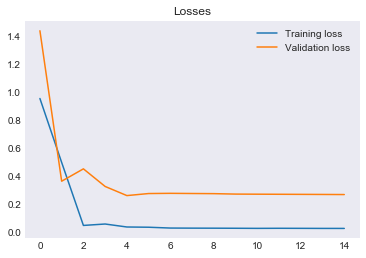

In [55]:
optimization_2.plot_losses()

We can observe a similar predicted sequence as before.
When we zoom into the spikes, similar behavior of the model can be observed, where predicted values mimic the actual values.
It seems like teacher forcing didn't solve the problem.

Test loss 8.7887


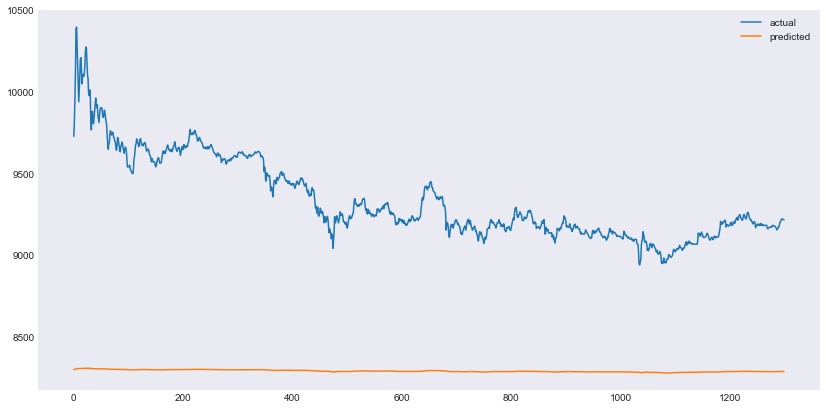

In [56]:
actual_2, predicted_2, test_loss_2 = optimization_2.evaluate(x_test, y_test, batch_size=100, future=5)
df_result_2 = to_dataframe(actual_2, predicted_2)
df_result_2 = inverse_transform(scaler, df_result_2, ["actual", "predicted"])
df_result_2.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_2)

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_2.iloc[2350:2450].plot(ax=axes[0], figsize=(14, 7))
df_result_2.iloc[16000:17500].plot(ax=axes[1], figsize=(14, 7))

TypeError: Empty 'DataFrame': no numeric data to plot

Let's generate 1000 time bars for the first test sequence with the model trained with teacher forcing.

In [0]:
y_pred2 = generate_sequence(scaler, optimization_2.model, x_sample)

In [0]:
plt.figure(figsize=(14, 7))
plt.plot(range(100), y_pred2[0][:100], color="blue", lw=2, label="Predicted VWAP")
plt.plot(range(100, 1100), y_pred2[0][100:], "--", color="blue", lw=2, label="Generated VWAP")
plt.plot(range(0, 1100), y_sample, color="red", label="Actual VWAP")
plt.legend()

An interesting observation about the generated sequence is that the generated values from the model trained with teacher forcing need longer to converge.
Another observation about the generated sequence is that when it is increasing, it will continue to increase to some point, 
then start to decrease and the pattern repeats until the sequence converges.
The pattern looks like a sine wave with decreasing amplitude.

## Conclusion

The result of this experiment is that the predictions of the model mimic actual values of the sequence.
The first and second model do not detect price changes before they occur.
Adding another feature (like volume) might help the model to detect the price changes before they occur, but then the model would need to generate two features to use the output of those as an input in next step, which would complicate the model.
Using a more complex model (multiple LSTMCells, increase the number of hidden units) might not help as the model has the capacity to predict VWAP time series as seen in the plots above.
More advanced methods of teacher forcing might help so that the model would improve sequence generation skills.

## References
 - [Time Sequence Prediction](https://github.com/pytorch/examples/tree/master/time_sequence_prediction)
 - [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
 - [What is Teacher Forcing for Recurrent Neural Networks?](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/)
 - [Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks](https://arxiv.org/abs/1506.03099)